### ANALYTIC SOLUTION FOR SCALAR WAVE 2D FREE SPACE ###

Based on Alford 1974 Geophysics. 
"ACCURACY OF FINITE-DIFFERENCE MODELING OF THE ACOUSTIC WAVE EQUATION"

Using cylindrical coordinates for a free a space medium homogeneous of velocity **$v$**. If the observer is at a **$\rho$** distance from the source. The analytical solution is written from the frequency domain solution as:

$$
U(\rho, t) = \frac{1}{2\pi}\int_{-\inf}^{+\inf}-F(\omega) i\pi H^{(2)}_{0}(k\rho)
$$

where $F(\omega)$ is the fourier transform of the source
function $f(t)$

$H^{(2)}$ is the second Hankel function of order 0

and $k = \omega/v $


###Source###

To avoid and diminish numerical errors we can use a source with analytical fourier transform known 

For simplicity on above equation we can use a simple Gauss Pulse:

$$ f(t) = te^{-\alpha t^2} $$ 

and its Fourier Transform $F(\omega)$ (note: in Alford's paper it was a bit different, I trust this one from Wolfram)

$$ F(\omega) = \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)}
$$

So simplifying the first one we get:

$$ U(\rho, t) = -i\pi H^{(2)}_{0}(k\rho_s)  \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

$$ U(\rho, t) =  H^{(2)}_{0}(k\rho_s)  \frac{\omega\pi}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

### Using partially analytical solution in frequency domain Ricker Wavelet ###


The wavelet is created in time then fourier transformed to frequency to apply<br/> 
the analytical solution and then apply back the inverse fourier transform to get it back to time

In [1]:
from scipy.special import hankel2
import numpy

def wave2d_analytic(rho, c, dt, source):
    """
    Analytic solution wave equation 2D for free space.
    Assume that source is at rho=0

    Do not evaluate at zero, solution not real!

    * rho : float
        distance to the source function
    * c : float
        velocity
    * dt : float
        sample rate for time source and analytical solution
    * source : 1D array
        source function in time

    References:

    Alford, R. M., Kelly, K. R., Boore, D. M. (1974) Accuracy of
    finite-difference modeling of the acoustic wave equation.
    Geophysics, 39(06), 834-842

    """
    n = source.size
    if rho/c > dt*n:  # make enough time for final solution
        newn = (rho/c)/dt + 16
        source = signal.resample(source, newn)
        n = newn
    # omega (2pi*f) increment for each omega that will be sampled
    ws = numpy.pi*2*numpy.arange(0, (1./dt), (1./dt)/n)
    # all k's = w/c in omega/frequency domain to evaluate the solution
    ks = ws/c
    # hankel filter kernel
    hankel = -1j*numpy.pi*hankel2(0, ks*rho)
    hankel[0] = 1j  # i infinity in limit
    sw = numpy.fft.fft(source)  # just go to frequency
    return numpy.real(numpy.fft.ifft(hankel*sw))

In [2]:
%cd Fatiando 

from fatiando.seismic import wavefd

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando


:0: FutureWarning: IPython widgets are experimental and may change in the future.


It's recommended to use the partially time / partially frequency analytical solution implementation.

Then you are able to compare and check how reliable is your F.D. using the error curve. 

###Simple grid F.D. free space testing###

In [3]:
"""
Seismic: 2D finite difference simulation of scalar wave
"""

from fatiando.seismic import wavefd
import numpy as np

vc=1500.
vshape = (400, 50)
mvel = np.ones(vshape)*vc
dx = dz = 5.
eps = 0.98*1./(5*max(dx, dz)*min(1./(2*dx),1./(2*dz)))
fc = eps*np.min(mvel)/(max(2*dx, 2*dz)) 
fc = fc/4. # frequency spectrum of Ricker is very broad fc is the peak 
#$fc = fc/1.7
xs, zs = 25.0, 320.0 # source (makes a lot of difference if u put close to z=0 (free up-surface problem))
xb, zb = 25.0, 120.0 # receivers

sim = wavefd.Scalar(mvel, (dx, dz))
sim.add_point_source((xs, zs), wavefd.Ricker(1., fc, 1./fc))

In [4]:
sim.run(550)
print "sample rate (s) ", sim.dt, " max time (s) ", sim.simsize*sim.dt

|##################################################|100% Ran 550 iterations in 8.81285 seconds.

sample rate (s)  0.0020208290378  max time (s)  1.11145597079


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


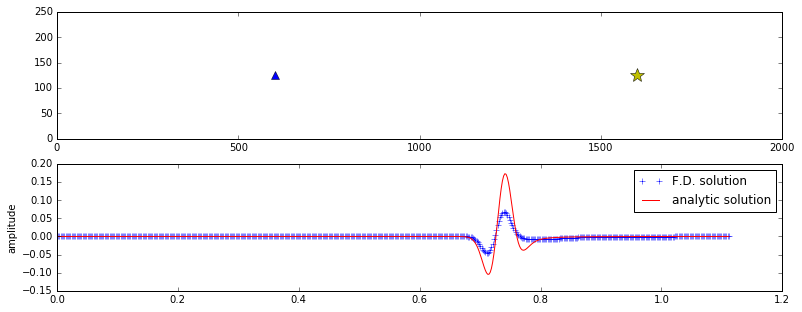

In [6]:
figure(figsize(13,5))
subplot(211)
plot(zb*dz, xb*dx, 'b^', markersize=8)
plot(zs*dz, xs*dx, '*y', markersize=15) 
xlim(0, vshape[0]*dz)
ylim(0, vshape[1]*dx)

subplot(212)
sensor_b = sim[:, zb, xb]
t = np.linspace(0., sim.simsize*sim.dt, sim.simsize)
wfricker = wavefd.Ricker(1., fc, 1./fc)
analytic_b = wave2d_analytic(abs(zb-zs)*dx, vc, sim.dt, wfricker(t))
plot(t, sensor_b,'b+', label='F.D. solution') 
plot(t, analytic_b, 'r-', label='analytic solution')
ylabel('amplitude')
legend()

## F. D. different type of errors ##


1. Errors due time shift (F.D. time derivative error in aproximation - just 2nd order)

2. Error due energy loss (F.D. numerical dispersion - spatial derivatives or all derivatives)<br/> 
   
There are no errors in energy loss due 2D vs 1D simulation, because analytic solution is 2D (radial)<br/> 
   
G value based on wave number (Alford) totally controls both!    

1. #### Calculate time shift error ####

2. #### Calculate energy amplitude loss ####

time shift error is (s)  -0.0020208290378 in samples (n)  1
relative time shift error is (%) 0.273224 
time shift error is (s)  -0.00151562177835 in samples (n)  0.75
relative time shift error is (%) 0.204778 


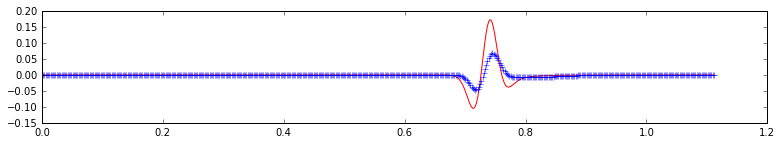

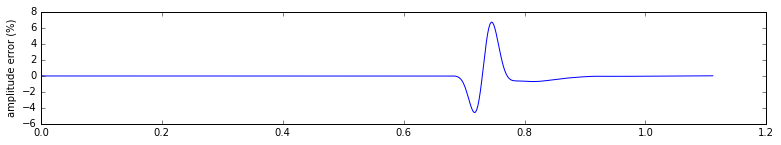

In [82]:
from scipy import signal

# one sample precision of time-shift
xycor = np.correlate(analytic_b, sensor_b, mode='full')
# would be nice to implement a half-sample or less time-shift calculation based on fourier resampling
sample_time_shit = (xycor.argmax()-size(analytic_b))+1 
print "time shift error is (s) ", -(sample_time_shit*sim.dt), "in samples (n) ", sample_time_shit
print "relative time shift error is (%) "+"%f "%(100.*sample_time_shit/analytic_b.argmax())

# resample to get until quarter-sample time-shift precison
analytic_b4 = signal.resample(analytic_b, np.size(analytic_b)*4)
sensor_b4 = signal.resample(sensor_b, np.size(sensor_b)*4)
xycor = np.correlate(analytic_b4, sensor_b4, mode='full')
sample_time_shit = (xycor.argmax()-size(analytic_b4))+1 
print "time shift error is (s) ", -(sample_time_shit*sim.dt/4.), "in samples (n) ", (sample_time_shit)/4.
print "relative time shift error is (%) "+"%f "%(100.*sample_time_shit/analytic_b4.argmax())

from collections import deque # shift in time to calculate energy loss
sensor_b_r = deque(sensor_b)
sensor_b_r.rotate(sample_time_shit)
sensor_b_r = np.array(sensor_b_r)

figure(figsize(13,2))
plot(t, analytic_b, 'r')
plot(t, sensor_b_r, 'b+')
figure(figsize(13,2))
relative_amp = (sensor_b_r+1.)-(analytic_b+1.)/(analytic_b+1.) # to avoid division by zero
plot(t, 100*relative_amp) # have to fix this. Find a better way to calculate
# amplitude error.
ylabel('amplitude error (%)')

### Make a graph of source position and time shift error ###

The closer to the grid boundary worse it is! Alford, Bartollo, Karan all say that!!!! 

Need to implement absorbing boundaries everywhere like di bartolo also 
padding and everything.

The source should not be at z=0, 1, or 2. Should be far from any grid boundary. 

If someone wants, just put water velocity above. I guess the the free earth is more closer to a absorbing boundary than to anything else. 

In [70]:
"""
Seismic: 2D finite difference simulation of scalar wave
"""
%cd Fatiando
%pylab inline
from fatiando.seismic import wavefd
import numpy as np

# Set the parameters of the finite difference grid
vshape = (200, 200)
ds = dx = dz = 12.5 # spacing
area = [0, vshape[0]*dz, 0, vshape[1]*dx]
# Set the parameters of the finite difference grid
vc=200.0
mvel = np.zeros(vshape)+vc
mvel[100:,100:] = 0.

# source frequency ? waveleght w = 0.0 second
eps = 0.98*1./(4*max(dx, dz)*min(1./(2*dx),1./(2*dz)))
fc = eps*vc/(max(2*dx, 2*dz))  
dt = wavefd.scalar_maxdt(area, vshape, np.max(mvel))

# Alford adapted by André
xs, zs = 107.0, 93.0 # source
# receivers
xa, za = 105.0, 95.0 # A - delta 7 - epsilon 2
xb, zb = 93.0, 93.0 # mirrored source positon to left
xc, zc = 97.0,105 # difraction


# Make a wave source from a mexican hat wavelet
#sources = [wavefd.MexHatSource(30000, 15000, area, shape, 100, fc, delay=2)]
# Make a wave source from a mexican hat wavelet, delay=3.5*wavelength
# first example R. M. Alford (x, z) 
sources = [wavefd.GaussSource((xs*ds, zs*ds), area, vshape,  1., fc)]

# Get the iterator for the simulation
#dt = wavefd.maxdt(area, shape, velocity)

maxt = 5.000
maxit = int(maxt/dt)
stations = [[xa*ds, za*ds], [xb*ds, zb*ds], [xc*ds, zc*ds]] # x, z coordinate of the seismometers
snapshot = 1 # Plot a snapshot of the simulation every 0.5 seconds
simulation = wavefd.scalar(mvel, area, dt, maxit, sources, stations=stations, snapshot=snapshot)

vmin = vmax = np.max(mvel)
vmin = vmax

R = dt*vmax/ds
print "fc :", fc, " maxit ", maxit
print "vmin : ", vmin, " vmax : ", vmax
print "R : ", R, "  of allowed < : ", np.sqrt(3./8.)  
print "Dt : ",  dt, "  of allowed < :", np.sqrt(3./8.)*ds/vmax
# Dave Hale criteria for dt
print "Dave Hale dt", ds/(2.*vmax)
print "Points by wavelenght: ", vmax/fc/ds, " recommended > 5 "
# the definition above of points by wavelength is not quite rigth is not using the
# spectrum fourier spectrum. 
print "Is there spatial Alias (based on frequency)? ", (vmax/fc < 2*ds)

figure(figsize(8,8))
imshow(mvel, origin='upper')
plot(xa, za, 'b^', markersize=8)
plot(xb, zb, 'g^', markersize=8)
plot(xc, zc, 'r^', markersize=8)
plot(xs, zs, '*y', markersize=15) 
xlim((0,200))
ylim((200,0))

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


AttributeError: 'module' object has no attribute 'scalar_maxdt'

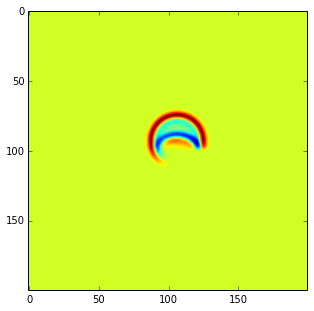

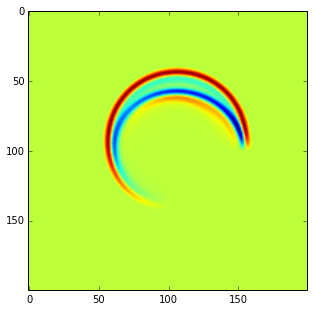

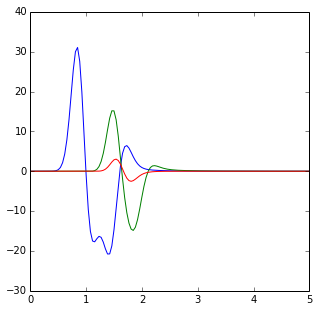

In [26]:
# numerical solution
frames = np.zeros((maxit, vshape[0], vshape[1]))
#
for i, frame, seismos in simulation:
    frames[i][:,:] = frame
    sensor_a = seismos[0]
    sensor_b = seismos[1]
    sensor_c = seismos[2]

figure(figsize=(5,5));
imshow(frames[48]); figure(figsize=(5,5));
imshow(frames[98]); figure(figsize=(5,5));#
hold(True);
t = np.linspace(0., maxit*dt, maxit)
plot(t, sensor_a,'b'); 
plot(t, sensor_b,'g'); 
plot(t, sensor_c,'r'); 
hold(False)

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando/fatiando/seismic
source:  9.89949493661 45.0
station:  7.07106781187 45.0
source:  9.89949493661 45.0
station:  9.89949493661 135.0
source:  9.89949493661 45.0
station:  5.83095189485 239.036243468


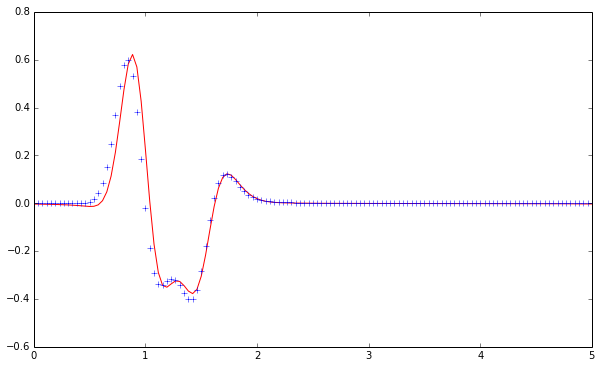

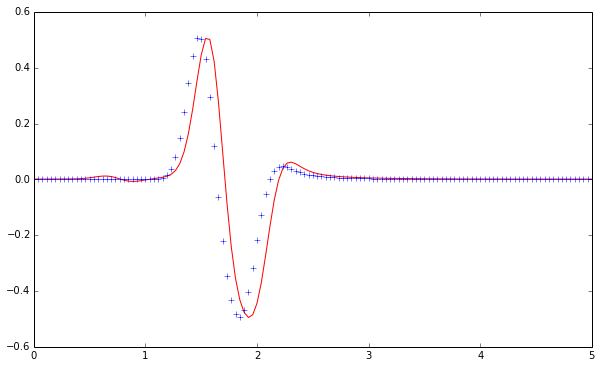

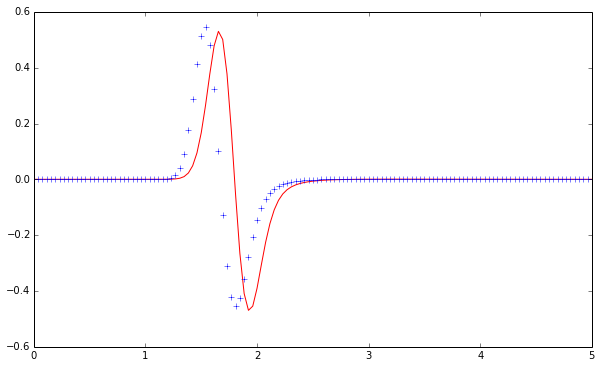

In [27]:
%cd Fatiando 
%cd fatiando/seismic
from analytic import wedge_cylindrical, _2cylindrical

def compare(fd_receiver, x, z, xs, zs, x0, z0, ds, vc, fc, dt, sources, maxt, maxit):
    rho_s, phi_s = _2cylindrical(xs, zs, x0, z0)
    rho, phi = _2cylindrical(x, z, x0, z0)
    print "source: ", rho_s, numpy.degrees(phi_s)
    print "station: ", rho, numpy.degrees(phi)
    sourcefunction = sources[0]
    t = np.linspace(0., maxt, maxit)
    source = -sourcefunction(t)    
    an_receiver = wedge_cylindrical(rho*ds, phi, rho_s*ds, phi_s, vc, source, dt)    
    fd_receiver = (fd_receiver-fd_receiver.min())/(fd_receiver.max()-fd_receiver.min())
    fd_receiver -= fd_receiver.mean()
    an_receiver = (an_receiver-an_receiver.min())/(an_receiver.max()-an_receiver.min())
    an_receiver -= an_receiver.mean()
    # plot fd and analytic solution
    pylab.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
    pylab.figure()
    plot(t,an_receiver,'r-')
    hold(True)
    plot(t,fd_receiver, 'b+')
    hold(False)
    pylab.rcParams['figure.figsize'] = 4, 4  # that's default image size for this interactive session

#ds = 100.
#vc = 6000.
#fc = 25.0
#dt = 0.01

compare(sensor_a, xa, za, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)
compare(sensor_b, xb, zb, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)
compare(sensor_c, xc, zc, xs, zs, 100., 100., ds, vc, fc, dt, sources, maxt, maxit)

### Emulating 2D field using analytical solution for free space 2D###

(bookmark:Fatiando) -> /home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando
/home/andre/PycharmProjects/fatiando/fatiando/seismic


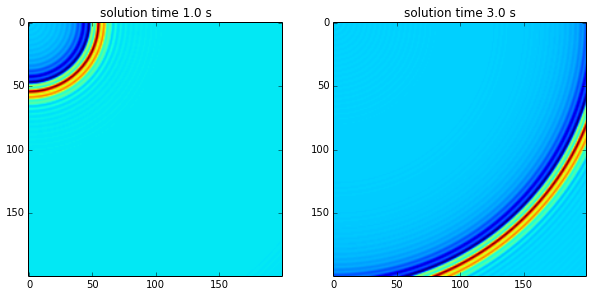

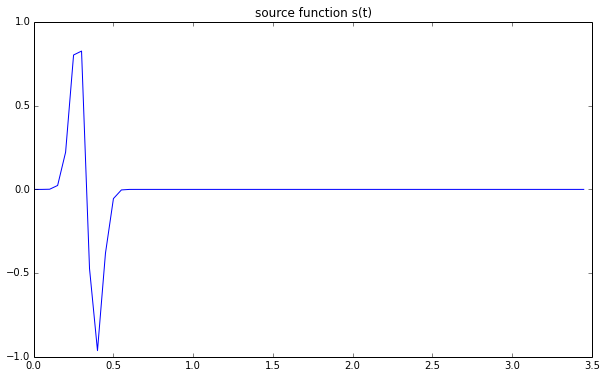

In [28]:
# Analytical solution 2D in math 
# answer posted in math.stackexchange 
# examples-of-2d-wave-equations-with-analytic-solutions/496611#496611

%cd Fatiando
%cd fatiando/seismic
from analytic import free_2d
import numpy as np

# a simple source function f(t) gauss derivative normalized
def gaussource(time, wlength, delay=None):
        if delay == None: # enough delay time
            delay = 3*wlength
        t = time - delay
        return ((2*np.sqrt(np.e)/(wlength))
               *t*np.exp(-2*(t**2)/(wlength**2)))

fc= 9.
c = 8000.
dt = 0.05
t = np.arange(0., 3.5, dt) # 35 seconds to evaluate the solution
source = -gaussource(t, 1./(fc)) # source and solution at zero source (source itself)
solutionD = free_2d(8000., c, source, dt) #solution at certain distance D=8000 metres e.g.   

# analytical solution (aproximated)
frame0 = np.zeros((200,200))
frame1 = np.zeros((200,200))

for i in xrange(200):
    for j in xrange(200):
        distance = np.sqrt(i**2+j**2)*100.
        frame0[i,j] = free_2d(distance, c, source, dt)[20]
    
for i in xrange(200):
    for j in xrange(200):
        distance = np.sqrt(i**2+j**2)*100.
        frame1[i,j] = free_2d(distance, c, source, dt)[60]

pylab.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
#plot(t,source)
#figure()
subplot(121)
imshow(frame0)
title('solution time 1.0 s')
subplot(122)
imshow(frame1)
title('solution time 3.0 s')
figure()
pylab.rcParams['figure.figsize'] = 6, 4  # that's default image size for this interactive session
plot(t, source)
title('source function s(t)')
pylab.rcParams['figure.figsize'] = 4, 4  # that's default image size for this interactive session